# A simple example

To illustrate the application of quantile regression neural networks, we consider a simple, 1-dimensional regression probelm with heteroscedastic uncertainty:

\begin{align}
y = \sin(x) + \cos(x) \cdot \mathcal{N}(0, 1)
\end{align}

The code below generates the synthetic training data consisting of $10^7$ randomly sampled $x$ values and corresponding $y$ values.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import quantnn
import quantnn.plots
quantnn.plots.set_style()

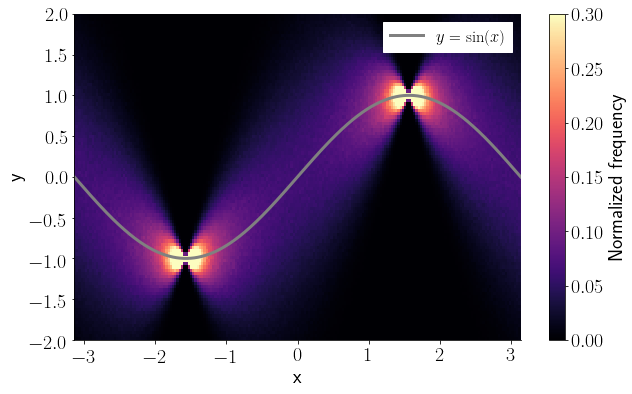

In [15]:
from quantnn.examples import simple
x, y = simple.create_training_data(10_000_000)
simple.plot_histogram(x, y)
plt.savefig("simple_training_data.png")

## Training the QRNN

The simplest way to train a quantile regression neural network is to use the ``quantnn.QRNN`` class, which provides a simple interface to define and and train QRNNs based on fully-connected, feed-forward neural networks.

To do this all we need to do is to choose which quantiles to predict as well as the basic parameters of the network architecture. More specifically, the following information must be provided to the constructor of the ``QRNN`` class:

1. The number of input features. For this simple example this just ``1``.
2. A list of the quantiles that we want to predict (``quantiles``)
3. A tuple describing the model architecture ``(n_layers, n_neurons, activation_function)``

> **Note:** quantnn will automatically choose the backend between Keras and PyTorch depending on which one is available on your system. You can specifically choose one over the other using the ``quantnn.qrnn.set_backend`` function.

In [3]:
import quantnn as q
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(1, quantiles=quantiles, model=model)

Finally we train the neural network on the training data. Here, we use only a subset of the data, in order to speed up the training process. We restart the training three times while lowering the learning rate, which leads to more accurate predicted quantiles.

In [5]:
training_data = (x[::10].reshape(-1, 1), y[::10].reshape(-1, 1))
qrnn.train(training_data=training_data,
           maximum_epochs=8,
           initial_learning_rate=0.1)
qrnn.train(training_data=training_data,
           maximum_epochs=4,
           initial_learning_rate=0.01)
qrnn.train(training_data=training_data,
           maximum_epochs=4,
           initial_learning_rate=0.001)

Epoch 1/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1123
Epoch 2/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1099
Epoch 3/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1089
Epoch 4/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1082
Epoch 5/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1075
Epoch 6/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1068
Epoch 7/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1067
Epoch 8/8
3906/3906 [==============================] - 11s 3ms/step - loss: 2.1061
Epoch 1/4
3906/3906 [==============================] - 11s 3ms/step - loss: 2.0979
Epoch 2/4
3906/3906 [==============================] - 11s 3ms/step - loss: 2.0976
Epoch 3/4
3906/3906 [==============================] - 12s 3ms/step - loss: 2.0976
Epoch 4/4
3906/3906 [==============================] - 12s 3ms/step - loss: 2.0976
Epoc

## Evaluation

To evaluate the QRNN we generate 1000 new $x$-value and use the ``predict`` method of the trained ``qrnn`` object to predict the quantiles of $y$.

In [6]:
n = 1_000
x_val = np.linspace(-np.pi, np.pi, n)
y_val = simple.create_validation_data(x_val)
y_pred = qrnn.predict(x_val.reshape(-1, 1))
y_mean = q.posterior_mean(y_pred, qrnn.quantiles)

We can now compare the quantiles predicted using the QRNN to the empirical quantiles from the training data. As can be seen from the plot below, the QRNN successfully predicts the quantiles of the posterior distribution.

[<matplotlib.lines.Line2D object at 0x7f8edc94ac50>, <matplotlib.lines.Line2D object at 0x7f8edc943d90>]


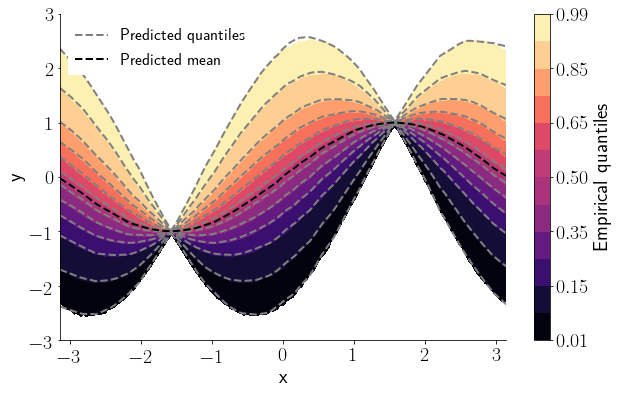

In [13]:
simple.plot_results(x, y, x_val, y_pred, y_mean, quantiles)
plt.savefig("simple_results.pdf")